## Frequency

In [1]:
import pandas as pd
import logging
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
import time
import pprint
import pickle
import random
import numpy as np
from sklearn.metrics import accuracy_score,precision_recall_curve, average_precision_score, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from pprint import pprint 
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import spacy
from tqdm import tqdm_notebook
import nltk
from unidecode import unidecode
from functools import reduce
import operator
from collections import OrderedDict
import re

In [3]:
from nltk import FreqDist
from sklearn.decomposition import PCA

In [4]:
nlp = spacy.load("it_core_news_sm")

#### Load discorsi analisi ####

In [5]:
cognomi = pickle.load( open( "cognomi_analisi.p", "rb" ) )

In [6]:
discorsi = {k:pickle.load( open( 'Discorsi_analisi/'+str(k)+'_discorsi_analisi.p', "rb" ) ) for k in cognomi.keys() }

#### Pulizia caratteri non alfanumerici

In [8]:
discorsi_puliti = {l:{} for l in discorsi.keys()}

In [9]:
separator = ','
for l in discorsi.keys():
    for cog in discorsi[l]:
        discorsi_puliti[l][cog] = []
        for d in discorsi[l][cog]:
            text = separator.join(d)
            reg = re.sub("[^A-Za-z']+", ' ', text)
            final = reg.split(' ')
            discorsi_puliti[l][cog].append(final)

### Frequenza
Lavoro su tutti i politici di ogni legis.
1. Import dei discorsi (senza stopwords)
2. Calcolo frequenza relativa dei termini
3. Confronto le frequenze di un politico con ogni altro unendo ogni volta i due dizionari di words e in caso mettendeo a 0 le frequenze delle parole non presenti
4. Faccio cosine similarity tra le due distribuzioni

In [10]:
def similarity(cog, c, words_pair):
    pol1 = {}
    pol2 = {}
      
    for w in words_pair:
        if w not in freqDist[cog]:
            pol1[w] = 0
        else:
            pol1[w] = freqDist[cog][w]
            
        if w not in freqDist[c]:
            pol2[w] = 0   
        else: 
            pol2[w] = freqDist[c][w]
            
    final_val = {}
    final_val[cog] = OrderedDict(sorted(pol1.items(), key=lambda t: t[0]))
    final_val[c] = OrderedDict(sorted(pol2.items(), key=lambda t: t[0]))
    
    only_val = {}
    only_val[cog] = []
    only_val[c] = []
    
    for k in final_val[cog].keys():
        only_val[cog].append(final_val[cog][k])
        
    for k in final_val[c].keys():
        only_val[c].append(final_val[c][k])
        
    return cosine_similarity([only_val[c]],[only_val[cog]])

In [11]:
def create_matrix(data_corpora):
    matrixdata_corpora = []
    
    for cog in data_corpora.keys():
        m = []
        for l in data_corpora[cog]:
            m.append((round(float(l[1][0]),5)))
        matrixdata_corpora.append(m)
        
    data = np.array(matrixdata_corpora)
    data = data.transpose()
    data = np.array(data)
    shape = ( len(data_corpora.keys()), len(data_corpora.keys()) )
    data = data.reshape( shape )
    data = np.array(data)

    return data

In [24]:
def heatmap_cosine(data, data_labels, title, save):
    #fig,ax= plt.subplots(2,2, figsize=(16,10))
    
    labels = []
    for k in data_labels.keys():
        if k =='RAFFAELE DELLA \ALLE':
            labels.append('DELLA VALLE')
        elif k =='IGNAZIO LA RUSSA':
            labels.append('LA RUSSA')
        elif k =='LUIGI DI MAIO':
            labels.append('DI MAIO')
        elif len(k.split(' '))>1:
            labels.append(k.split(' ')[-1])
        else:
            labels.append(k)
    
    fig,ax= plt.subplots()
    
    ax.matshow(data, cmap=plt.cm.Blues, vmin=min(0,min([min(elem) for elem in data])-0.15), vmax=1,)
    
    for i in range(len(data_labels.keys())):
        for j in range(len(data_labels.keys())):
            c = data[j,i]
            ax.text(i, j, round(c,3), va='center', ha='center', color ='white', weight='bold', size=14)
    
    ax.set_title(title, size = 20)
    
    ax.set_xticks(np.arange(len((data_labels.keys()))))
    ax.set_yticks(np.arange(len(data_labels.keys())))

    ax.set_yticklabels(labels, size = 14, rotation = 45)
    ax.set_xticklabels(labels, size = 14, rotation = 90 )
    
    #plt.colorbar(data=data)

    fig.set_size_inches(17, 17)
    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
    plt.show()
    #fig.savefig('Images/Frequency/'+save+'.png', dpi=100, bbox_inches='tight')

In [13]:
#unisco tutti i discorsi di ogni politico in un unico discorso, non tengo la divisione per legis
corpora = {}

for l in cognomi.keys():
    for cog in cognomi[l]:
        corpora[cog] = [reduce(operator.concat, discorsi_puliti[l][cog])]

### Frequenza semplice

In [15]:
freqDist = {}
words = {}

for cog in corpora.keys():
        freqDist[cog] = FreqDist(corpora[cog][0])
        words[cog] = list(freqDist[cog].keys())

In [16]:
for cog in corpora.keys():
    for w in words[cog]:
        freqDist[cog][w] = freqDist[cog][w] / len(corpora[cog][0])

In [17]:
data_corpora = {cog:[] for cog in corpora.keys()}
not_considered_words = set()

for cog in corpora.keys():
    for c in corpora.keys():
        words_pair = set()
        words_pair = set(words[cog]).union(set(words[c]))
        
        words_final = []
        for w in words_pair:
            if freqDist[c][w] > 0.02 and freqDist[cog][w] > 0.02:
                not_considered_words.add(w)
            else: 
                words_final.append(w)
                
        val = similarity(cog,c,words_final)
        data_corpora[cog].append((c,val))

In [18]:
data = create_matrix(data_corpora)

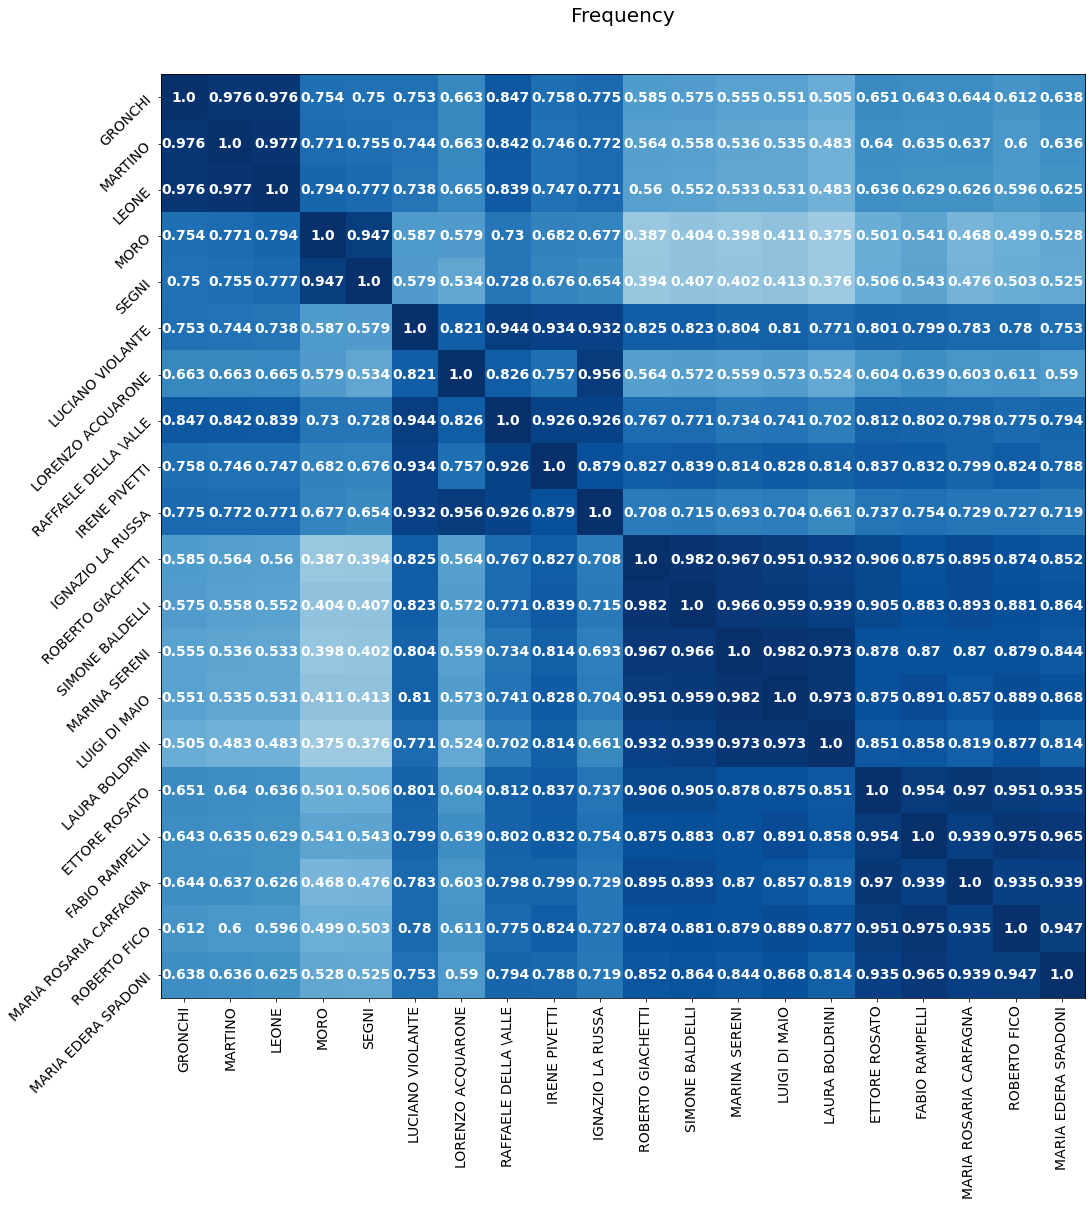

In [19]:
heatmap_cosine(data, data_corpora, 'Frequency')

## TFIDF frequency
Rifaccio la stessa cosa ma al posto che usare la frequenza uso TFIDF

### Calcolo TF ###

In [14]:
tokens = lambda text: [x.lemma_ for x in nlp(text) if x.pos_ not in ['PUNCT', 'SPACE'] and not x.is_stop]
all_tokens = lambda text: [x.lemma_ for x in nlp(text) if x.pos_ not in ['PUNCT', 'SPACE']]

In [15]:
nlp.max_length = 2548747

In [16]:
TF = {}
k = 0.5 
cont = 0
separator = ' '

for l in discorsi_puliti.keys():
    for cog in discorsi_puliti[l].keys():
        text = discorsi_puliti[l][cog]
        text = [separator.join(elem) for elem in text]
        text = reduce(operator.concat, text)
   
        freq = Counter(tokens(text)).most_common() #le stopwrods le ho già tolte
    
        max_freq = freq[0][1] # normalizzo con il termine più frequente nel documento
        TF[cog] = {elem[0]: k+(1-k) * (elem[1]/max_freq) for elem in freq } #ogni politico è come se fosse un documento
        print(cog) # qui

GRONCHI
MARTINO
LEONE
MORO
SEGNI
IRENE PIVETTI
RAFFAELE DELLA \ALLE
LORENZO ACQUARONE
LUCIANO VIOLANTE
IGNAZIO LA RUSSA
ROBERTO GIACHETTI
SIMONE BALDELLI
MARINA SERENI
LUIGI DI MAIO
LAURA BOLDRINI
ETTORE ROSATO
FABIO RAMPELLI
MARIA ROSARIA CARFAGNA
ROBERTO FICO
MARIA EDERA SPADONI


In [17]:
pprint(list(sorted(TF['GRONCHI'].items(), key=lambda x: x[1]))[:10])

[('approv', 0.5002488800398208),
 ('qto', 0.5002488800398208),
 ('aereo', 0.5002488800398208),
 ('ltalia', 0.5002488800398208),
 ('libare', 0.5002488800398208),
 ('beirut', 0.5002488800398208),
 ('misurc', 0.5002488800398208),
 ('aeronavigazione', 0.5002488800398208),
 ('otaggio', 0.5002488800398208),
 ('fncolta', 0.5002488800398208)]


In [18]:
words_tf = {}
for cog in corpora.keys():
    words_tf[cog] = list(TF[cog].keys())

In [ ]:
for cog in corpora:
    print(cog)
    pprint(list(sorted(TF[cog].items(), key=lambda x: -x[1]))[:10])

In [19]:
def similarity_tf(cog, c, words_pair, TF):
    pol1 = {}
    pol2 = {}
      
    for w in words_pair:
        if w not in TF[cog]:
            pol1[w] = 0.0
        else:
            pol1[w] = TF[cog][w]
            
        if w not in TF[c]:
            pol2[w] = 0.0   
        else: 
            pol2[w] = TF[c][w]
            
    final_val = {}
    final_val[cog] = OrderedDict(sorted(pol1.items(), key=lambda t: t[0]))
    final_val[c] = OrderedDict(sorted(pol2.items(), key=lambda t: t[0]))
    
    only_val = {}
    only_val[cog] = []
    only_val[c] = []
    
    only_val[cog] = [final_val[cog][k] for k in final_val[cog].keys()]
    only_val[c] = [final_val[c][k] for k in final_val[c].keys()]
        
    return cosine_similarity([only_val[c]],[only_val[cog]])

In [21]:
data_tf = {}

for cog in corpora.keys():
    data_tf[cog] = []
    for c in corpora.keys():
        words_pair = set()
        words_pair = set(words_tf[cog]).union(set(words_tf[c]))
            
        val = similarity_tf(cog,c,words_pair, TF)
        data_tf[cog].append((c,val)) 
    print(cog)

GRONCHI
MARTINO
LEONE
MORO
SEGNI
LUCIANO VIOLANTE
LORENZO ACQUARONE
RAFFAELE DELLA \ALLE
IRENE PIVETTI
IGNAZIO LA RUSSA
ROBERTO GIACHETTI
SIMONE BALDELLI
MARINA SERENI
LUIGI DI MAIO
LAURA BOLDRINI
ETTORE ROSATO
FABIO RAMPELLI
MARIA ROSARIA CARFAGNA
ROBERTO FICO
MARIA EDERA SPADONI


In [22]:
data = create_matrix(data_tf)

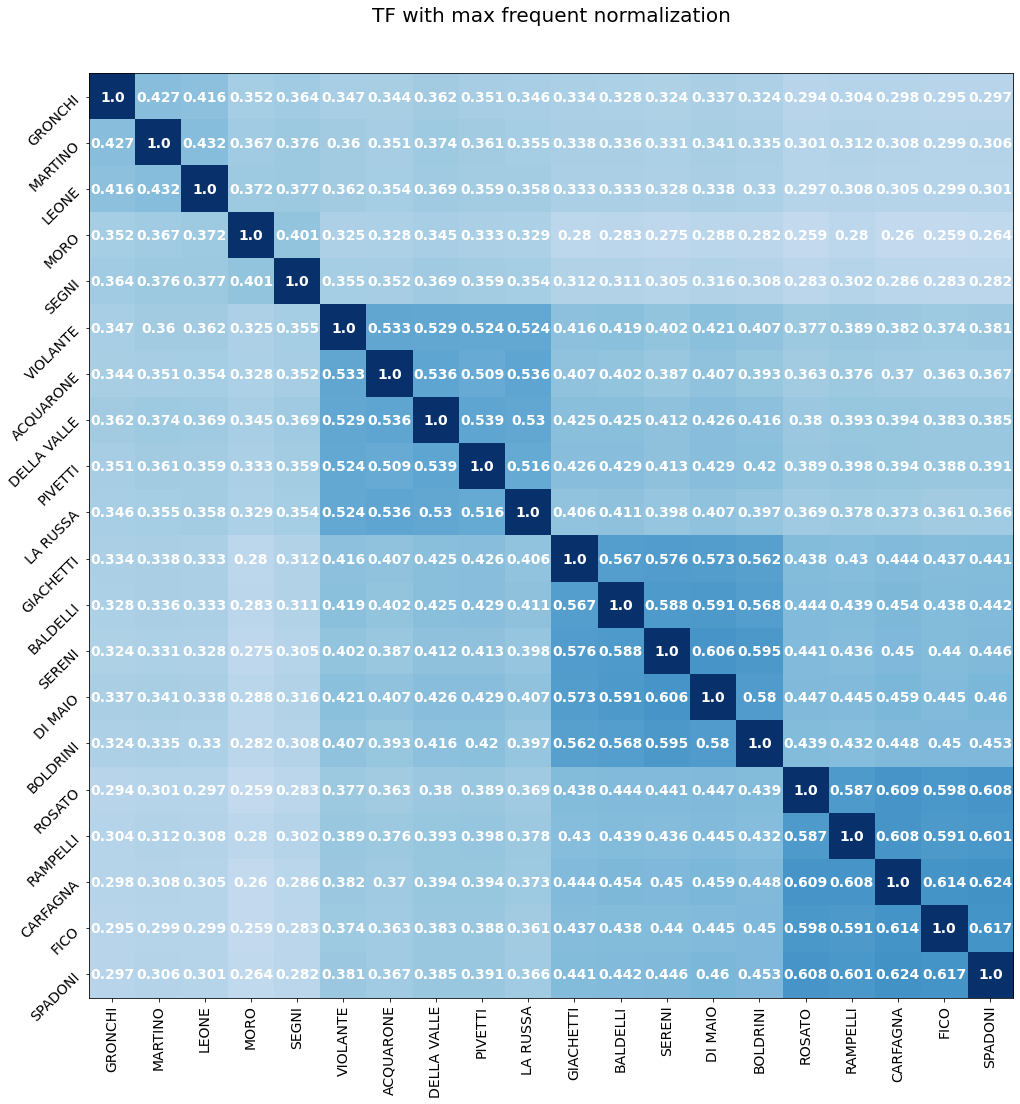

In [25]:
heatmap_cosine(data, data_tf, 'TF with max frequent normalization', 'TF_freq_norm')

#### Calcolo TFIDF

In [26]:
DF = {}
N = len(corpora)

for cog in TF.keys():
    for term in TF[cog].keys():
        if term not in DF.keys():
            DF[term] = 1
        else:
            DF[term] = DF[term] +1
            
IDF = lambda x: np.log(N / DF[x])

<b> TFIDF con parole che ci sono almeno in 2 documenti </b> <br>
In quanto noi volgiamo torvare quelli con il linguaggio più simile, se una parola esiste solo in un documento significa che non sarà mai comparata con nessuno.

In [27]:
IDF_red = lambda x: np.log(N / DF_reduct[x])

In [28]:
len([1 for k in DF.keys() if DF[k]>1]) # considero solo parole che ci sono almeno in 2 doc

22658

In [29]:
DF_reduct = {k:DF[k] for k in DF.keys() if DF[k]>1}

In [30]:
TfIdf_reduct = {}
for cog, bow in TF.items():
    TfIdf_reduct[cog] = {w:round(bow[w] * IDF_red(w),3) for w in bow.keys() if w in DF_reduct.keys()}

In [31]:
len(TfIdf_reduct['SEGNI']) 
# non cambio il valore di tfidf degli altri token ma diminuisco il numero di quelli
# da confrontare che sarebbero a 0 perchè li ha un solo politico

9516

In [ ]:
for cog in ['MORO', 'SEGNI']:
    print(cog)
    pprint(list(sorted(TfIdf_reduct[cog].items(), key=lambda x: -x[1]))[:20])

In [33]:
for cog in corpora:
    print(cog)
    pprint(list(sorted(TfIdf_reduct[cog].items(), key=lambda x: -x[1]))[:10])

GRONCHI
[('votazionc', 1.154),
 ('fuschini', 1.154),
 ('censuario', 1.154),
 ('pnrlnmentnri', 1.153),
 ('ddare', 1.153),
 ('cumento', 1.153),
 ('prowisorio', 1.153),
 ('ghena', 1.153),
 ('raccini', 1.153),
 ('togliatt', 1.153)]
MARTINO
[('distillazione', 1.155),
 ('svolgerlocomunicare', 1.154),
 ('rispondereporre', 1.154),
 ('locatizio', 1.154),
 ('votazionc', 1.154),
 ('svolgerloporre', 1.154),
 ('magnani', 1.153),
 ('facoltti', 1.153),
 ('cecche', 1.153),
 ('civitanova', 1.153)]
LEONE
[('rispondereporre', 1.155),
 ('glieri', 1.154),
 ('eminente', 1.154),
 ('chirurgo', 1.153),
 ('vetrario', 1.153),
 ('cirenaica', 1.153),
 ('docenza', 1.153),
 ('lerno', 1.153),
 ('votazioiic', 1.153),
 ('pastorizio', 1.153)]
MORO
[('zolfifera', 1.155),
 ('istruttore', 1.154),
 ('ammiraglio', 1.154),
 ('cavarzere', 1.154),
 ('emigratorio', 1.153),
 ('borghesia', 1.153),
 ('contradizione', 1.153),
 ('disgraziato', 1.153),
 ('cooperatore', 1.153),
 ('vivero', 1.153)]
SEGNI
[('concime', 1.154),
 ('fucinare

In [117]:
words_tfidf_reduct = {}
for cog in corpora:
    words_tfidf_reduct[cog] = list(TfIdf_reduct[cog].keys())

In [129]:
data_tfidf_reduct = {}

for cog in corpora:
    data_tfidf_reduct[cog] = []
    for c in corpora:
        words_pair = set()
        words_pair = set(words_tfidf_reduct[cog]).union(set(words_tfidf_reduct[c]))
                
        val = similarity_tf(cog,c,words_pair, TfIdf_reduct)
        data_tfidf_reduct[cog].append((c,val)) 
    print(cog)

GRONCHI
MARTINO
LEONE
MORO
SEGNI
LUCIANO VIOLANTE
LORENZO ACQUARONE
RAFFAELE DELLA \ALLE
IRENE PIVETTI
IGNAZIO LA RUSSA
ROBERTO GIACHETTI
SIMONE BALDELLI
MARINA SERENI
LUIGI DI MAIO
LAURA BOLDRINI
ETTORE ROSATO
FABIO RAMPELLI
MARIA ROSARIA CARFAGNA
ROBERTO FICO
MARIA EDERA SPADONI


In [130]:
data = create_matrix(data_tfidf_reduct)

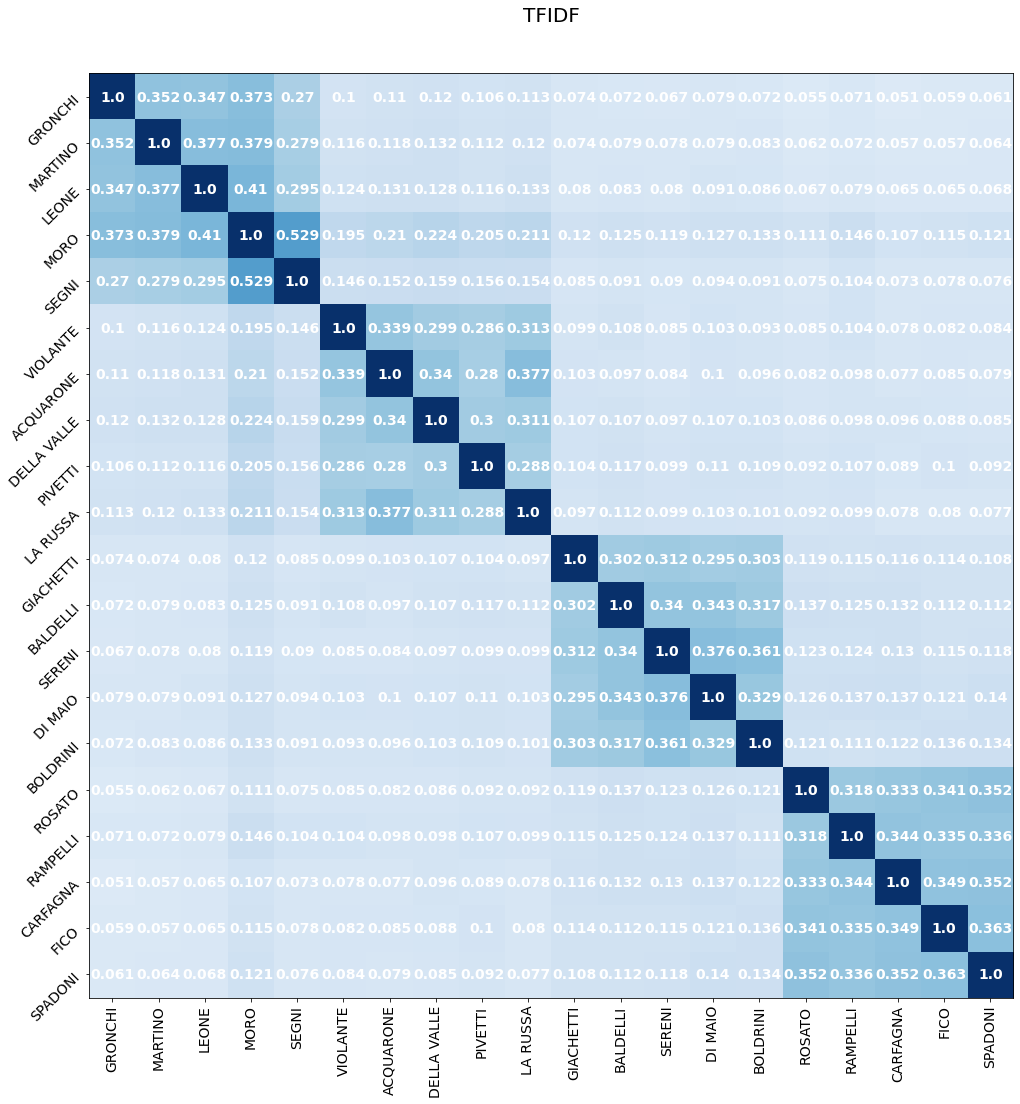

In [139]:
heatmap_cosine(data, data_tfidf_reduct, 'TFIDF', 'tfidf_filt1')

<b> TFIDF senza filtro </b>

In [140]:
TfIdf = {}
for cog, bow in TF.items():
    TfIdf[cog] = {w:round(bow[w] * IDF(w),3) for w in bow.keys()}

In [141]:
for cog in corpora:
    print(cog)
    pprint(list(sorted(TfIdf[cog].items(), key=lambda x: -x[1]))[:10])

GRONCHI
[('bencivenga', 1.502),
 ('ponibile', 1.501),
 ('passeri', 1.501),
 ('npp', 1.5),
 ('ongo', 1.5),
 ('insisterel', 1.5),
 ('capitolol', 1.5),
 ('esidente', 1.5),
 ('massara', 1.5),
 ('lunigiana', 1.5)]
MARTINO
[('literno', 1.505),
 ('stazzare', 1.504),
 ('balipedio', 1.502),
 ('approvarel', 1.501),
 ('raselli', 1.501),
 ('scigno', 1.501),
 ('camposar', 1.501),
 ('fabbricabile', 1.5),
 ('disporne', 1.5),
 ('costruirvi', 1.5)]
LEONE
[('motopeschereccio', 1.502),
 ('arduini', 1.501),
 ('charlie', 1.501),
 ('suicidare', 1.501),
 ('veterano', 1.5),
 ('chaplin', 1.5),
 ('itta', 1.5),
 ('grumo', 1.5),
 ('arpino', 1.5),
 ('formis', 1.5)]
MORO
[('scabinato', 1.501),
 ('pigione', 1.5),
 ('controfirmare', 1.5),
 ('cinematografia', 1.499),
 ('prosciugamento', 1.499),
 ('banditismo', 1.499),
 ('verdetto', 1.499),
 ('contradizioni', 1.499),
 ('miglioratrice', 1.499),
 ('topolino', 1.499)]
SEGNI
[('mezzadrile', 1.504),
 ('agricolturu', 1.502),
 ('ioreste', 1.501),
 ('agricollura', 1.501),
 ('a

In [142]:
words_tfidf = {}
for cog in corpora:
    words_tfidf[cog] = list(TfIdf[cog].keys())

In [143]:
data_tfidf = {}

for cog in corpora:
    data_tfidf[cog] = []
    for c in corpora:
        words_pair = set()
        words_pair = set(words_tfidf[cog]).union(set(words_tfidf[c]))
                
        val = similarity_tf(cog,c,words_pair, TfIdf)
        data_tfidf[cog].append((c,val)) 

In [144]:
data = create_matrix(data_tfidf)

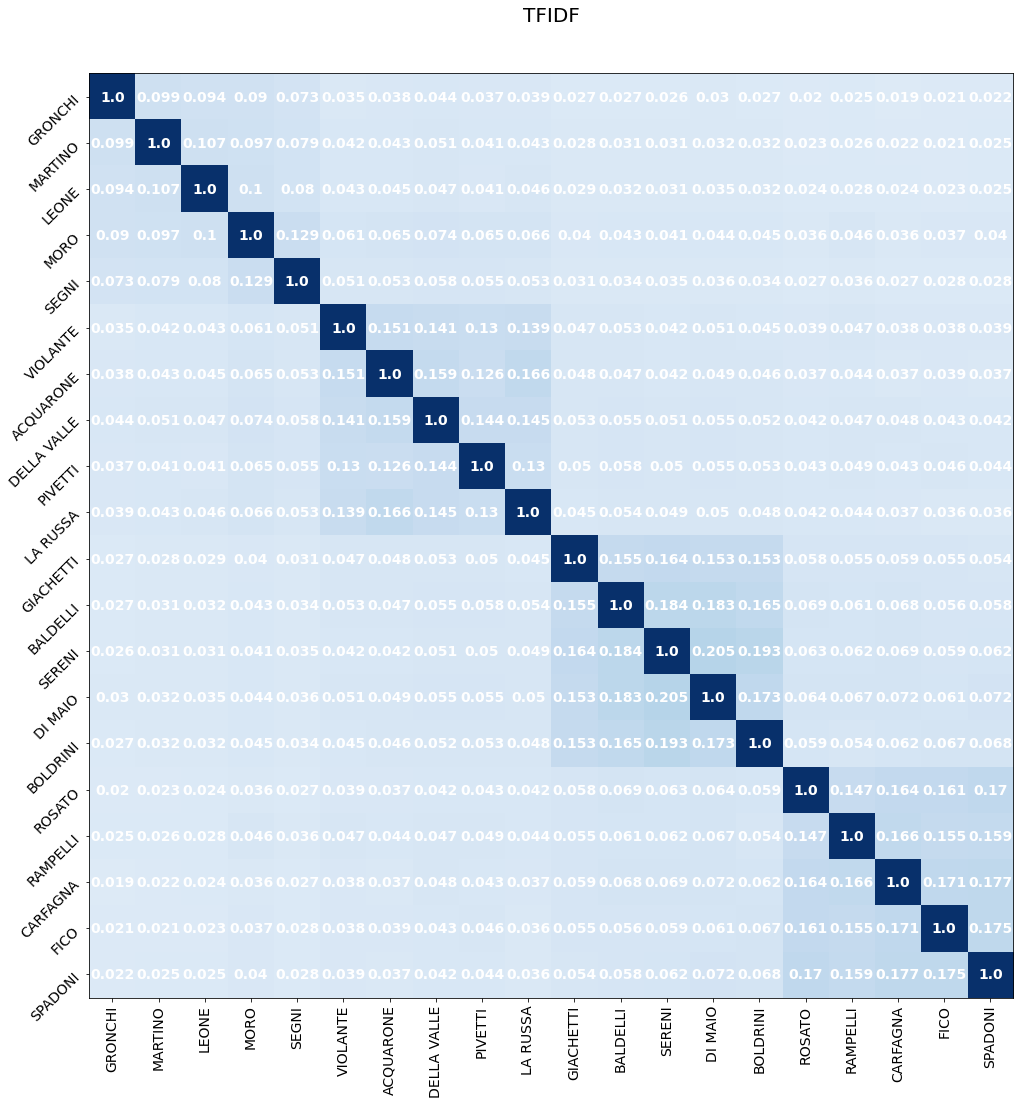

In [145]:
heatmap_cosine(data, data_tfidf, 'TFIDF', 'tfidf_nofilt') 
#molto peggio di quello con filtro

## Word Embedding
Rifaccio la stessa cosa usando Word2Vec, quindi con il contesto.

In [5]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

### Long word embdedding

In [9]:
discorsi_long = pickle.load( open( 'discorsi_analisi_long.p', "rb" ) )

In [10]:
def skip(sequence, n, s):
    ngrams = []
    for i in range(len(sequence)):
        for z in range(s):
            seq = [sequence[i]] + sequence[i+z+1:i+z+n]
            if len(seq) == n and seq not in ngrams:
                ngrams.append(tuple(seq))
    return ngrams

In [11]:
corpora_long = {} 

In [12]:
from datetime import datetime

In [13]:
nlp.max_length = 5624620

In [14]:
tokens_long = lambda text: [x.lemma_ for x in nlp(text) if x.pos_ not in ['PUNCT', 'SPACE'] and not x.is_stop] 

In [16]:
# TROVO TF SOLO PER LE 400 PAROLE NON PER W2V

TF_long = {}
k = 0.5
cont = 0
separator = ' '


for cog in discorsi_long.keys():
        text = discorsi_long[cog]
        text = [separator.join(elem) for elem in text]
        text = reduce(operator.concat, text)
   
        freq = Counter(tokens_long(text)).most_common() #le stopwrods le ho già tolte
    
        max_freq = freq[0][1] # normalizzo con il termine più frequente nel documento
        TF_long[cog] = {elem[0]: k+(1-k)*(elem[1]/max_freq) for elem in freq}
        print(cog) 

GRONCHI
MARTINO
LUCIANO VIOLANTE
LORENZO ACQUARONE
ROBERTO GIACHETTI
SIMONE BALDELLI
ETTORE ROSATO
FABIO RAMPELLI


<b> Trovo sequenze </b>

In [17]:
tokens_w2v = lambda text: [x for x in nlp(text) if x.pos_ not in ['PUNCT', 'SPACE']] 

In [19]:
sequences_long = {}
seq = []
separator = ' '
n = 3
s = 1

for cog in discorsi_long:
    seq = []
    print(datetime.now())
    for doc in discorsi_long[cog]: 
            doc = separator.join(doc)
            doc = tokens_w2v(doc)
            token = skip(doc, n, s)
            for a, b, c in token:
                seq.append([str(a), str(b), str(c)])
    sequences_long[cog] = seq
    print(cog) 

2021-01-29 16:00:11.267519
GRONCHI
2021-01-29 16:02:32.757065
MARTINO
2021-01-29 16:03:16.295531
LUCIANO VIOLANTE
2021-01-29 16:04:19.652097
LORENZO ACQUARONE
2021-01-29 16:05:01.065959
ROBERTO GIACHETTI
2021-01-29 16:07:13.960793
SIMONE BALDELLI
2021-01-29 16:08:48.318268
ETTORE ROSATO
2021-01-29 16:09:29.273431
FABIO RAMPELLI


In [279]:
pickle.dump(sequences_long, open( 'Discorsi_analisi/sequences_long.p', "wb" ) ) 

In [355]:
sequences_long = pickle.load(open('Discorsi_analisi/sequences_long.p', "rb" ))

In [20]:
for cog in sequences_long:
    print(len(sequences_long[cog]))

895135
282646
416574
282872
802606
577773
237533
246925


<b> Creo modello </b>

In [21]:
#withsequences

models_long = {}
for cog, sequence in sequences_long.items():
        
        models_long[cog] = Word2Vec(sequences_long[cog], min_count=20)
        print(cog)

GRONCHI
MARTINO
LUCIANO VIOLANTE
LORENZO ACQUARONE
ROBERTO GIACHETTI
SIMONE BALDELLI
ETTORE ROSATO
FABIO RAMPELLI


### Confronto most similar ###

In [23]:
words_w2v_long = {cog:list(models_long[cog].wv.vocab) for cog in sequences_long.keys() }

In [25]:
word2vec_confronto_tf = {cog:[] for cog in sequences_long.keys()}

for pol1 in sequences_long.keys():
    for pol2 in sequences_long.keys():
        w1 = set([elem[0] for elem in list(sorted(TF_long[pol1].items(), key=lambda x: -x[1]))[:400]]).intersection(words_w2v_long[pol1])
        w2 = set([elem[0] for elem in list(sorted(TF_long[pol2].items(), key=lambda x: -x[1]))[:400]]).intersection(words_w2v_long[pol2])
        
        word_coppia = w1.intersection(w2)
        lista_cont = []
        
        for w in word_coppia:
            sim1 = [x[0] for x in models_long[pol1].wv.most_similar(positive=w)][:10]
            sim2 = [x[0] for x in models_long[pol2].wv.most_similar(positive=w)][:10]
            lista_cont.append(len(set(sim1).intersection(set(sim2)))/10)
        
        word2vec_confronto_tf[pol1].append((pol2,[sum(lista_cont)/len(lista_cont)]))
    print(pol1)

GRONCHI
MARTINO
LUCIANO VIOLANTE
LORENZO ACQUARONE
ROBERTO GIACHETTI
SIMONE BALDELLI
ETTORE ROSATO
FABIO RAMPELLI


In [26]:
pprint(word2vec_confronto_tf)

{'ETTORE ROSATO': [('GRONCHI', [0.0847133757961783]),
                   ('MARTINO', [0.08639455782312921]),
                   ('LUCIANO VIOLANTE', [0.1285714285714285]),
                   ('LORENZO ACQUARONE', [0.09999999999999995]),
                   ('ROBERTO GIACHETTI', [0.16684491978609634]),
                   ('SIMONE BALDELLI', [0.15638297872340423]),
                   ('ETTORE ROSATO', [1.0]),
                   ('FABIO RAMPELLI', [0.24155844155844172])],
 'FABIO RAMPELLI': [('GRONCHI', [0.08509316770186326]),
                    ('MARTINO', [0.09240506329113916]),
                    ('LUCIANO VIOLANTE', [0.1320224719101124]),
                    ('LORENZO ACQUARONE', [0.1172413793103448]),
                    ('ROBERTO GIACHETTI', [0.14838709677419365]),
                    ('SIMONE BALDELLI', [0.16358695652173913]),
                    ('ETTORE ROSATO', [0.24155844155844172]),
                    ('FABIO RAMPELLI', [1.0])],
 'GRONCHI': [('GRONCHI', [1.0]),
             

In [32]:
data = create_matrix(word2vec_confronto_tf)

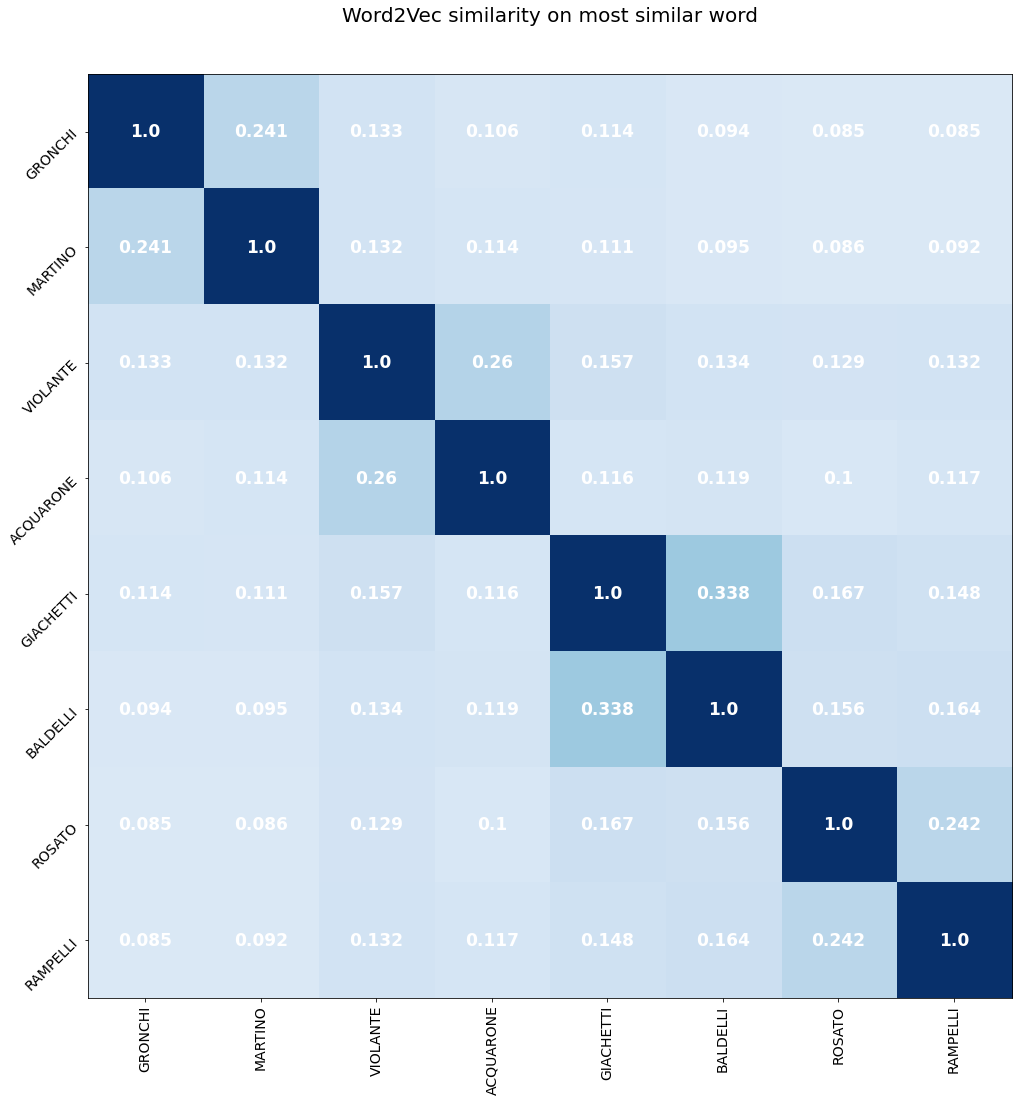

In [33]:
heatmap_cosine(data, word2vec_confronto_tf, 'Word2Vec similarity on most similar word', 'word2vec') #no lemma, si stop